# Sperm Detection using EfficientDet

## Part 1 - Data processing

-------------------------------------

Firstly, let's download the VISEM dataset for Sperm Detection problem:
- Train: https://drive.google.com/file/d/1kCyVy9pQJXEEkfANbSDuLdQoI1pyKjsN/view?usp=share_link
- Val: https://drive.google.com/file/d/1x1ldk9pFPusqLBEEi1n1lMQnozzrDtKC/view?usp=share_link

Assumed that you put them in the folder `visem-raw`, so we will have the following structure:

    visem-raw/
        |- Train/
            |- 13/
                |- images/
                |- labels/
                |- ...
            |- ...
        |- Val
            |- 11/
                |- images/
                |- labels/
                |- ...
            |- ...
    
The format of current annotations for objects in data is **YOLO format**, which means it has 5 value determining the object: `class`, `x_center`, `y_center`, `width`, `height`, where `x_center`, `y_center`, `width`, `height` are in [0, 1]. For example:

In [2]:
ex_img_path = './visem-raw/Val/11/images/11_frame_1000.jpg'
ex_ann_path = './visem-raw/Val/11/labels/11_frame_1000.txt'
with open(ex_ann_path, 'r') as f:
    print(f.readline())

0 0.26484375 0.4354166666666667 0.0265625 0.0375



To have a better understanding, we will visualize the annotations of image `11_frame_1000.jpg`:

In [3]:
import cv2
import matplotlib.pyplot as plt
import numpy as np

colors = {
    0: (0, 0, 255),
    1: (0, 255, 0),
    2: (255, 0, 0),
}
classes = {
    0: 'sperm',
    1: 'cluster',
    2: 'small/pinhead'
}

def draw_box(img_path, label_path):
    with open(label_path, 'r') as f:
        label = f.read()
    img = cv2.imread(img_path)
    height, width, _ = img.shape
    for line in label.split('\n'):
        box = [np.float64(x) for x in line.split()]
        if len(box) < 5:
            continue
        class_id = int(box[0])
        x_c = (width * box[1])
        y_c = (height * box[2])
        w = (width * box[3])
        h = (height * box[4])
        x_min, y_min, x_max, y_max = int(x_c - w/2), int(y_c - h/2), int(x_c + w/2), int(y_c + h/2)
        cv2.rectangle(img, pt1=(x_min, y_min), pt2=(x_max, y_max),
                      color=colors[class_id], thickness=1)
        img = cv2.putText(img, text=classes[class_id], org=(x_min - 5, y_min - 5),
                          fontFace=cv2.FONT_HERSHEY_SIMPLEX, fontScale=0.4,
                          color=colors[class_id], thickness=1, lineType=cv2.LINE_AA)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    plt.figure(figsize=(16, 8))
    plt.imshow(img)
    plt.axis('off')

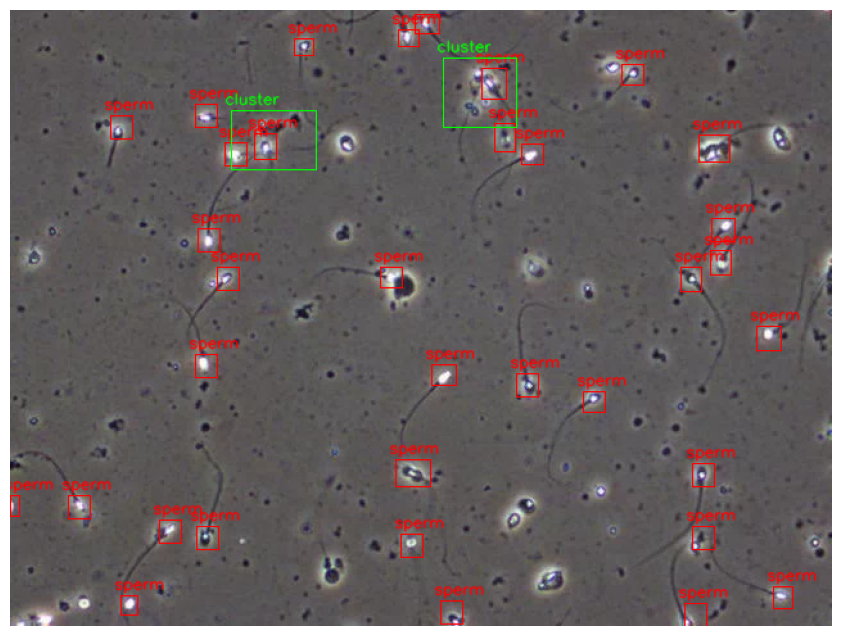

In [4]:
draw_box(ex_img_path, ex_ann_path)

Now, we will convert it to **COCO format**. In this format, the dataset folder will be in the following structure:

    |- project_name/
        |- train_set_name/
            |- *.jpg
        |- val_set_name/
            |- *.jpg
        |- annotations
            |- instances_{train_set_name}.json
            |- instances_{val_set_name}.json

The content of JSON annotation files (for object detection) will be in this format:

```python
    "images": [
        {
            "file_name": "image_1.jpg",
            "height": 480,
            "width": 640,
            "id": 0  # id of images will increase from 0
        },
        ...
    ],
    "categories": [
        {
            "supercategory": "none",
            "id": 1, # id of categories will increase from 1
            "name": "cate_1"
        },
        ...
    ],
    "annotations": [
        {
            "id": 1,  # id of objects will increase from 0
            "image_id": 0, # id of the image this object belong to
            "category_id": 1,
            "bbox": [
                x,
                y,
                width,
                height
            ], # x, y, width, height are interger
            "area": width * height,
            "iscrowd": 0,
        },
        ...
    ]
```

In fact, the id of categories can start from 0. However, we set it as 1 for later use (the repo we will use for training the model requires it to start from 1).

In [5]:
import os
import json
import shutil
from tqdm import tqdm
import numpy as np

def gen_coco(root='./visem-raw/Train', img_dst_folder='', ann_dst_path=''):
    img_id = 0
    obj_id = 0

    categories = [
        {
            "supercategory": "none",
            "id": 1,
            "name": "sperm"
        },
        {
            "supercategory": "none",
            "id": 2,
            "name": "cluster"
        },
        {
            "supercategory": "none",
            "id": 3,
            "name": "small/pinhead"
        },
    ]
    images = []
    annotations = []

    for video in tqdm(os.listdir(root)):
        video_path = os.path.join(root, video)

        img_folder = os.path.join(video_path, 'images')
        label_folder = os.path.join(video_path, 'labels')

        for img_name in os.listdir(img_folder):
            label_name = img_name.split('.')[0] + '.txt'
            if not os.path.exists(os.path.join(label_folder, label_name)):
                continue

            img_path = os.path.join(img_folder, img_name)
            img = cv2.imread(img_path)
            img_h, img_w = img.shape[0], img.shape[1]

            shutil.copy(img_path, os.path.join(img_dst_folder, img_name))

            images.append({
                "id": img_id,
                "file_name": img_name,
                "width": img_w,
                "height": img_h
            })

            with open(os.path.join(label_folder, label_name), 'r') as f:
                anns = f.read()
                for line in anns.split('\n'):
                    if len(line) < 1:
                        continue
                    
                    box = [np.float64(x) for x in line.split()]
                    cls = int(box[0])
                    x_c = img_w * box[1]
                    y_c = img_h * box[2]
                    w = img_w * box[3]
                    h = img_h * box[4]
                    x_min, y_min, w, h = int(x_c - w/2), int(y_c - h/2), int(w), int(h)

                    annotations.append({
                        "id": obj_id,
                        "image_id": img_id,
                        "category_id": cls + 1,     # because category's id starts from 1
                        "iscrowd": 0,
                        "bbox": [
                            x_min, y_min, w, h
                        ],
                        "area": w * h
                    })
                    obj_id += 1

            img_id += 1

    json_dict = {
        'categories': categories,
        'images': images,
        'annotations': annotations
    }

    with open(ann_dst_path, 'w') as f:
        json.dump(json_dict, f)

In [6]:
!mkdir ./visem-coco
!mkdir ./visem-coco/annotations
!mkdir ./visem-coco/train
!mkdir ./visem-coco/val

In [7]:
gen_coco(root='./visem-raw/Val/', img_dst_folder='./visem-coco/val', ann_dst_path='./visem-coco/annotations/instances_val.json')

100%|██████████| 4/4 [00:26<00:00,  6.65s/it]


In [8]:
gen_coco(root='./visem-raw/Train/', img_dst_folder='./visem-coco/train', ann_dst_path='./visem-coco/annotations/instances_train.json')

100%|██████████| 16/16 [01:27<00:00,  5.49s/it]


And now, we have done the data processing step!

In [10]:
%ls ./visem-coco

annotations/  train/  val/


In [11]:
%ls ./visem-coco/annotations

instances_train.json  instances_val.json
